In [1]:
#!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [2]:
#!pip install torch torch-geometric

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipdb

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [3]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


Archive:  drive/MyDrive/slt_challenge/transcripts_outputFiles.zip
   creating: transcripts_outputFiles/
   creating: transcripts_outputFiles/SFT_outputFiles/
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-103.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-034.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-131.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-039.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-059.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-073.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-030.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-080.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-069.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-test-002.txt  
  inflating: transcripts_outputFiles/SFT_outputFiles/Process-rec-083.txt  
  inflating: tra

In [28]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    x = torch.stack(features)  # Node feature matrix

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=label)
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)


def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)

class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 3):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  # Train
  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):  # train for 50 epochs
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = cross_entropy(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all)
    return logits_all, pred_all, results, disp


def calc_metrics(actual_labels, pred_vals, print_results=True):
  results = {}
  results['accuracy'] = accuracy_score(actual_labels, pred_vals)
  results['f1'] = f1_score(actual_labels, pred_vals, average='macro')
  results['precision'] = precision_score(actual_labels, pred_vals, average='macro')
  results['recall'] = recall_score(actual_labels, pred_vals, average='macro')

  cm = confusion_matrix(actual_labels, pred_vals)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['HC', 'MCI', 'DEM'])
  # print and plot results
  if print_results:
    for metric, value in results.items():
      print(f'{metric}: {value:.3f}')
    disp.plot()
    plt.show()
  return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, class_weights=None, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = n_tasks * num_classes  # input dimensions equals to number of tasks (CTD, SFT, PFT) * number of classes
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if class_weights is not None:
        class_weights = class_weights.to(features.device)  # Move class weights to the same device as the model
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
Class weights for base model:  tensor([0.6410, 0.8772, 3.3333])
Class weights for combined model:  tensor([0.6410, 0.8681, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11571
Epoch 50, Loss: 0.48664
Epoch 100, Loss: 0.04700
Epoch 150, Loss: 0.00444
Epoch 200, Loss: 0.00190
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.440
f1: 0.431
precision: 0.438
recall: 0.462


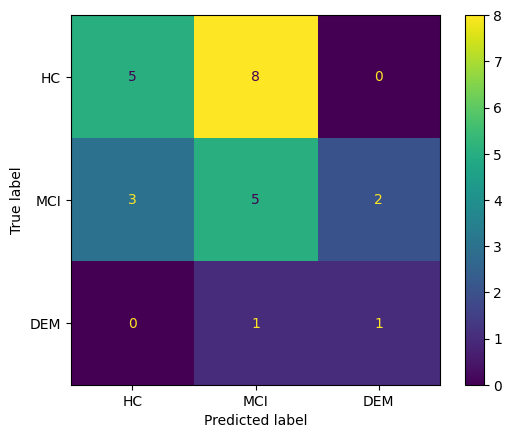

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.344
f1: 0.254
precision: 0.263
recall: 0.258


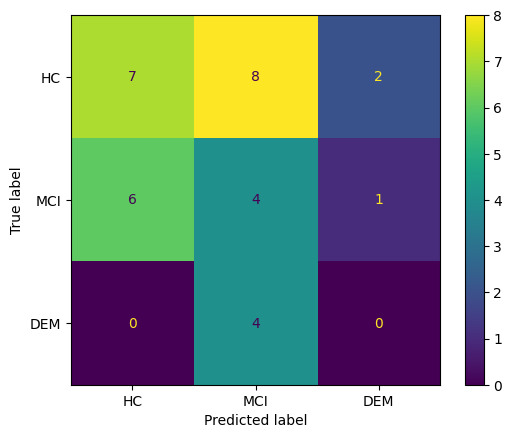

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11585
Epoch 50, Loss: 0.55009
Epoch 100, Loss: 0.05229
Epoch 150, Loss: 0.00510
Epoch 200, Loss: 0.00224
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.406
f1: 0.293
precision: 0.284
recall: 0.319


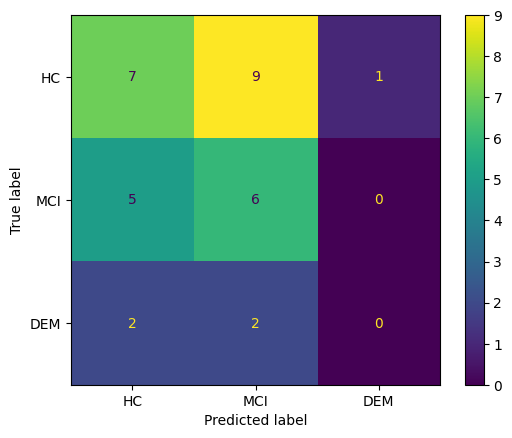

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11408
Epoch 50, Loss: 0.22673
Epoch 100, Loss: 0.00579
Epoch 150, Loss: 0.00182
Epoch 200, Loss: 0.00102
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.320
f1: 0.215
precision: 0.210
recall: 0.221


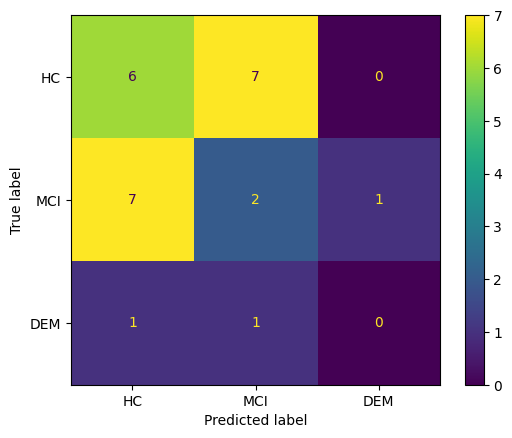

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.438
f1: 0.312
precision: 0.307
recall: 0.317


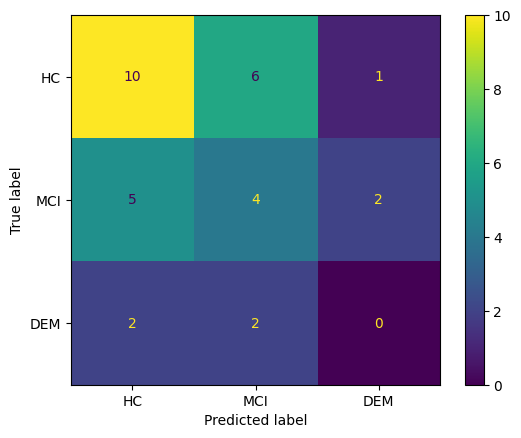

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11367
Epoch 50, Loss: 0.32773
Epoch 100, Loss: 0.00661
Epoch 150, Loss: 0.00189
Epoch 200, Loss: 0.00104
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.469
f1: 0.339
precision: 0.342
recall: 0.348


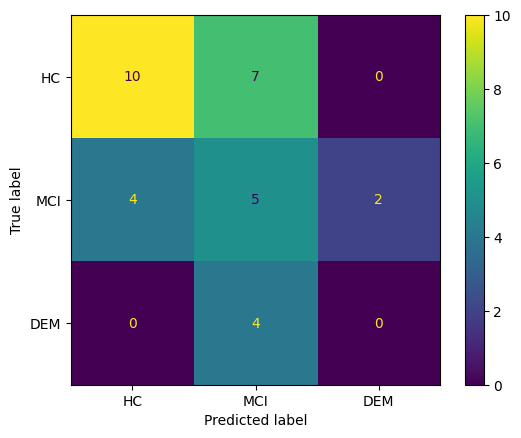

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08156
Epoch 50, Loss: 0.00317
Epoch 100, Loss: 0.00029
Epoch 150, Loss: 0.00019
Epoch 200, Loss: 0.00013
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.320
f1: 0.285
precision: 0.265
recall: 0.354


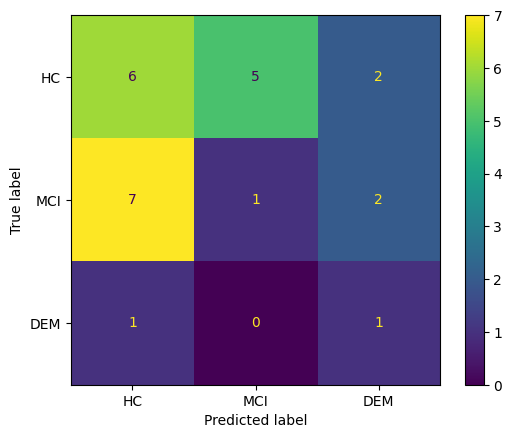

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.531
f1: 0.473
precision: 0.518
recall: 0.461


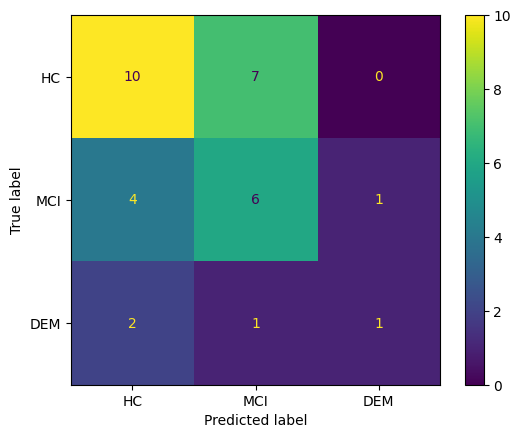

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08508
Epoch 50, Loss: 0.01183
Epoch 100, Loss: 0.00063
Epoch 150, Loss: 0.00036
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.562
f1: 0.463
precision: 0.476
recall: 0.459


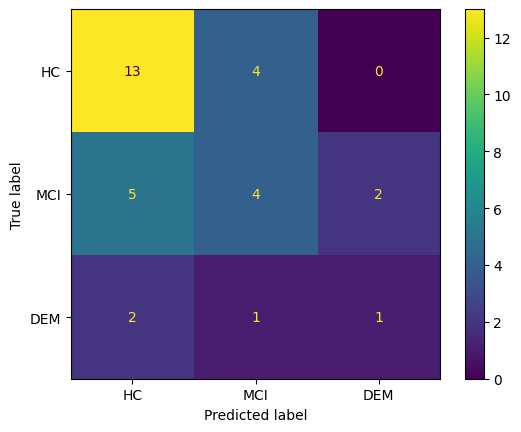

Fold 1:

    train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}),
    train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
    dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 10, 2: 4})
Class weights for base model:  tensor([0.6536, 0.8547, 3.3333])
Class weights for combined model:  tensor([0.6510, 0.8503, 3.4722])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11363
Epoch 50, Loss: 0.48334
Epoch 100, Loss: 0.02186
Epoch 150, Loss: 0.00343
Epoch 200, Loss: 0.00173
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.560
f1: 0.387
precision: 0.376
recall: 0.405


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


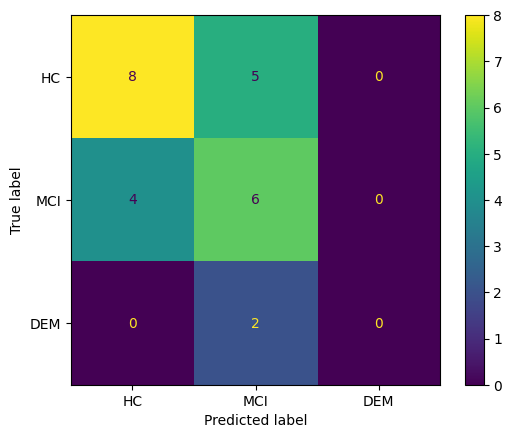

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.438
f1: 0.317
precision: 0.317
recall: 0.319


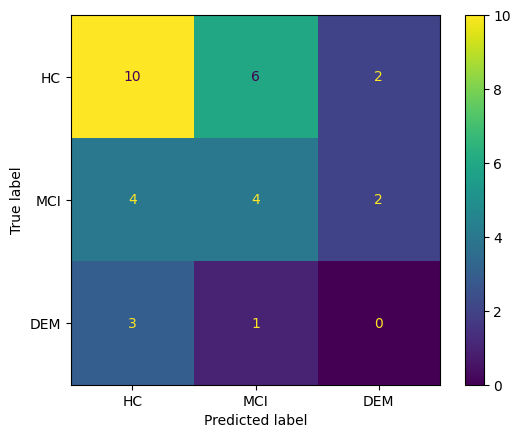

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11448
Epoch 50, Loss: 0.53648
Epoch 100, Loss: 0.06811
Epoch 150, Loss: 0.00564
Epoch 200, Loss: 0.00245
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.420
precision: 0.426
recall: 0.420


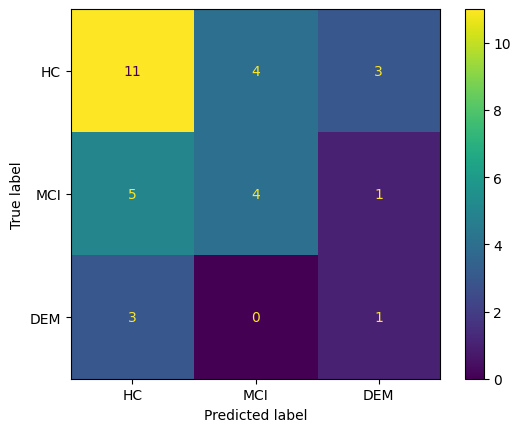

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11360
Epoch 50, Loss: 0.22678
Epoch 100, Loss: 0.00350
Epoch 150, Loss: 0.00131
Epoch 200, Loss: 0.00078
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.400
f1: 0.275
precision: 0.265
recall: 0.287


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


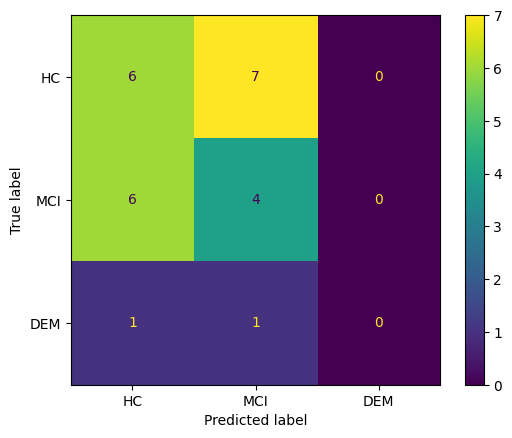

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.407
precision: 0.384
recall: 0.441


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


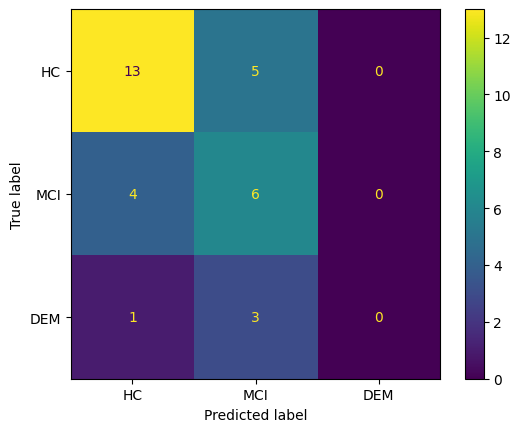

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.11202
Epoch 50, Loss: 0.35236
Epoch 100, Loss: 0.00748
Epoch 150, Loss: 0.00196
Epoch 200, Loss: 0.00108
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.594
f1: 0.383
precision: 0.361
recall: 0.411


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


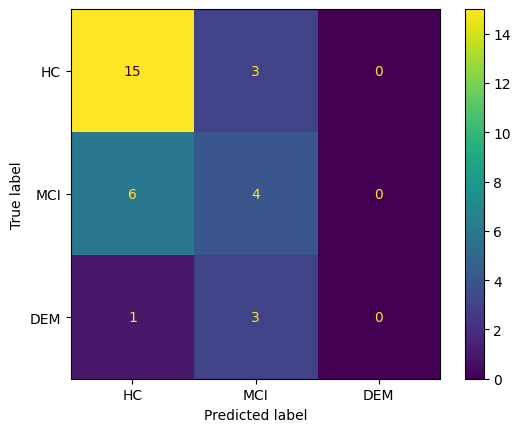

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08241
Epoch 50, Loss: 0.00174
Epoch 100, Loss: 0.00021
Epoch 150, Loss: 0.00015
Epoch 200, Loss: 0.00011
Validating on meta model train set...
Setting batch size to  25
accuracy: 0.520
f1: 0.492
precision: 0.492
recall: 0.497


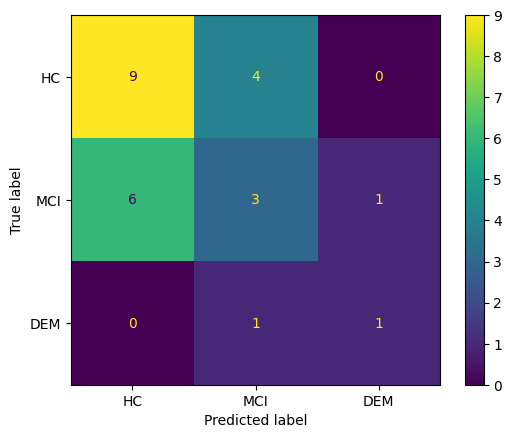

Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.384
precision: 0.389
recall: 0.385


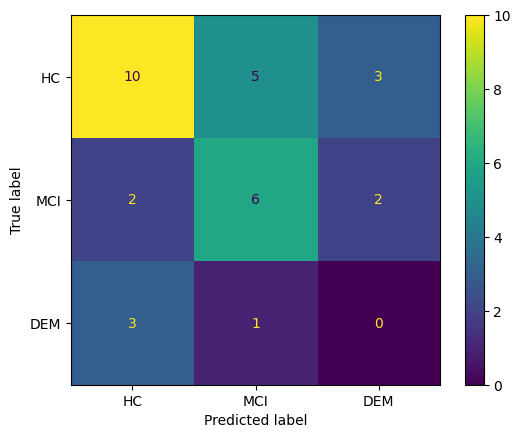

Training on base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 1.08311
Epoch 50, Loss: 0.00556
Epoch 100, Loss: 0.00048
Epoch 150, Loss: 0.00030
Epoch 200, Loss: 0.00021
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.500
f1: 0.369
precision: 0.383
recall: 0.356


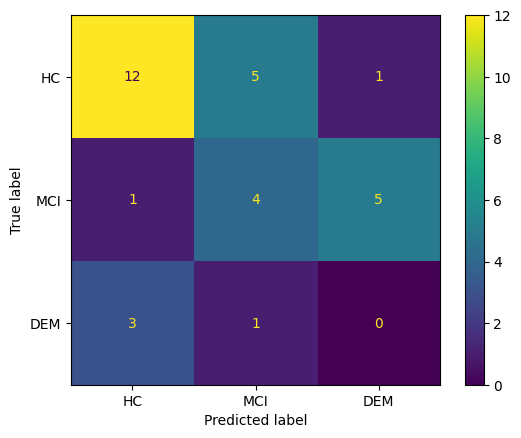

Fold 2:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11407
Epoch 50, Loss: 0.45662
Epoch 100, Loss: 0.03177
Epoch 150, Loss: 0.00370
Epoch 200, Loss: 0.00166
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.385
f1: 0.281
precision: 0.289
recall: 0.278


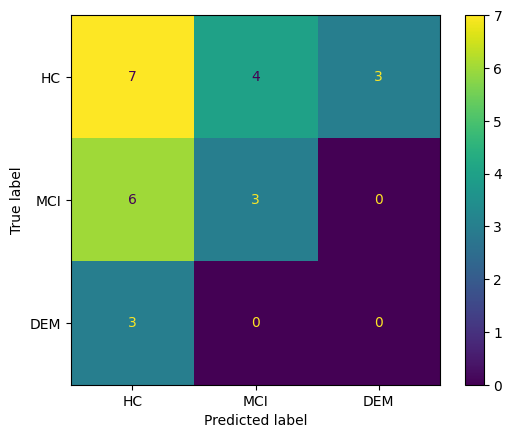

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.326
precision: 0.333
recall: 0.321


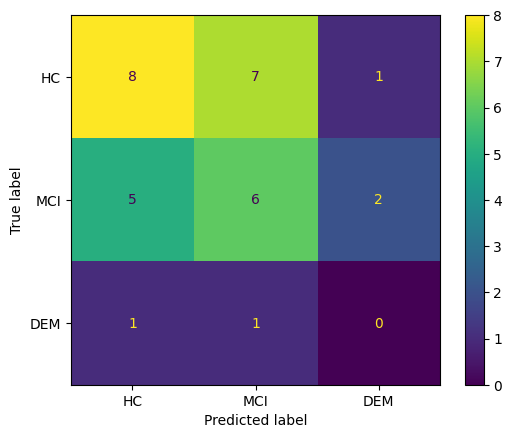

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11444
Epoch 50, Loss: 0.54945
Epoch 100, Loss: 0.07403
Epoch 150, Loss: 0.00665
Epoch 200, Loss: 0.00274
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.516
f1: 0.362
precision: 0.363
recall: 0.362


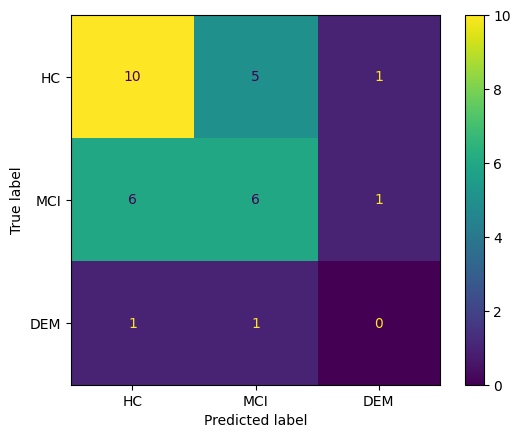

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11107
Epoch 50, Loss: 0.23220
Epoch 100, Loss: 0.00321
Epoch 150, Loss: 0.00117
Epoch 200, Loss: 0.00069
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.235
precision: 0.230
recall: 0.241


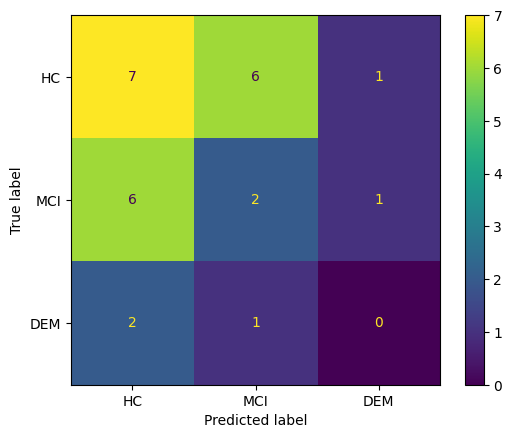

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.368
precision: 0.350
recall: 0.415


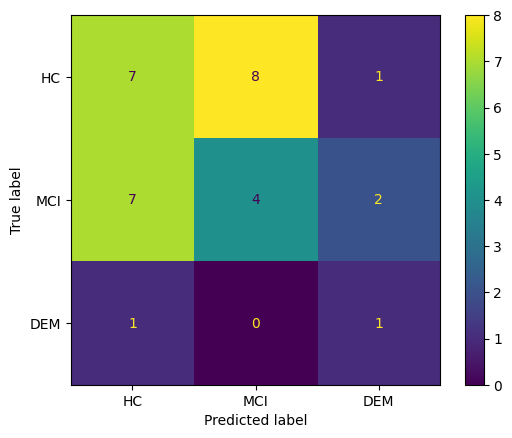

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11161
Epoch 50, Loss: 0.31460
Epoch 100, Loss: 0.00561
Epoch 150, Loss: 0.00157
Epoch 200, Loss: 0.00088
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.416
precision: 0.400
recall: 0.462


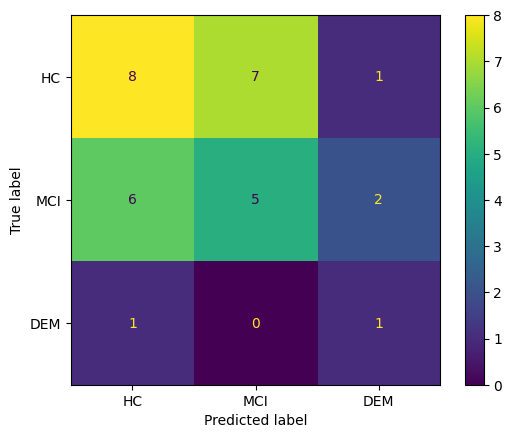

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08957
Epoch 50, Loss: 0.00571
Epoch 100, Loss: 0.00043
Epoch 150, Loss: 0.00027
Epoch 200, Loss: 0.00018
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.462
f1: 0.400
precision: 0.400
recall: 0.413


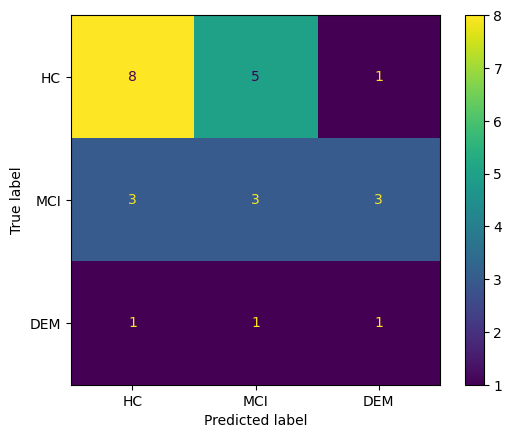

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.426
precision: 0.411
recall: 0.457


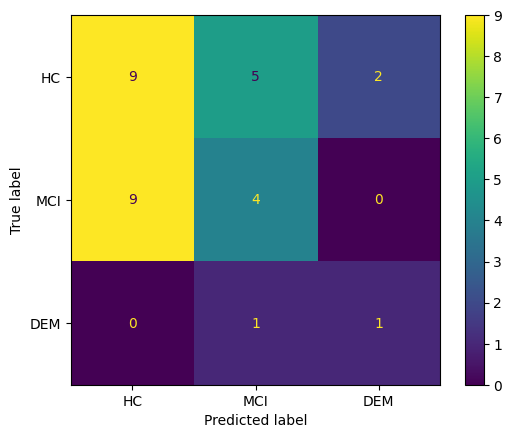

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08671
Epoch 50, Loss: 0.02133
Epoch 100, Loss: 0.00080
Epoch 150, Loss: 0.00044
Epoch 200, Loss: 0.00029
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.287
precision: 0.291
recall: 0.290


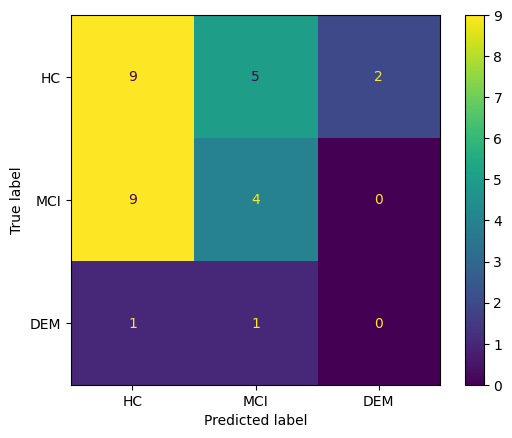

Fold 3:

    train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
    dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
Class weights for base model:  tensor([0.6410, 0.9009, 3.0303])
Class weights for combined model:  tensor([0.6364, 0.9130, 3.0000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11391
Epoch 50, Loss: 0.55982
Epoch 100, Loss: 0.05315
Epoch 150, Loss: 0.00539
Epoch 200, Loss: 0.00235
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.538
f1: 0.372
precision: 0.363
recall: 0.386


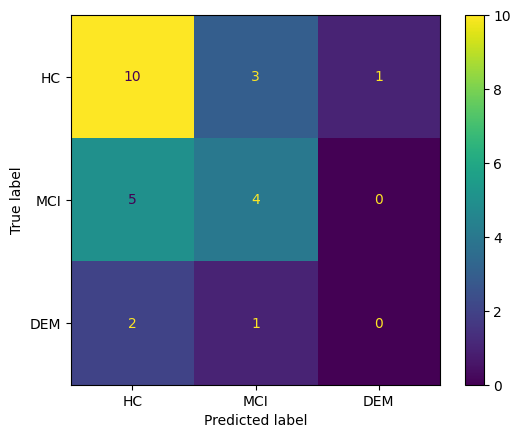

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.613
f1: 0.422
precision: 0.417
recall: 0.429


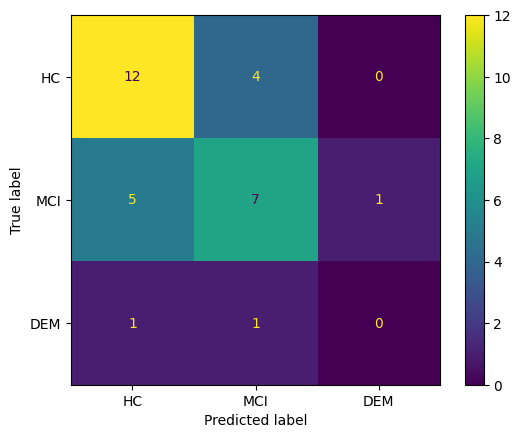

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11445
Epoch 50, Loss: 0.60929
Epoch 100, Loss: 0.11345
Epoch 150, Loss: 0.00967
Epoch 200, Loss: 0.00353
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.361
precision: 0.357
recall: 0.378


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


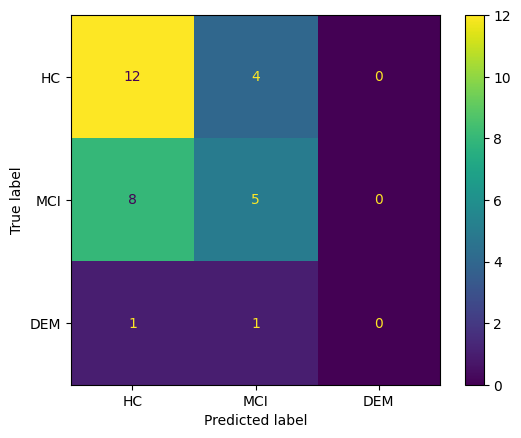

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11310
Epoch 50, Loss: 0.21318
Epoch 100, Loss: 0.00305
Epoch 150, Loss: 0.00122
Epoch 200, Loss: 0.00073
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.500
f1: 0.311
precision: 0.317
recall: 0.336


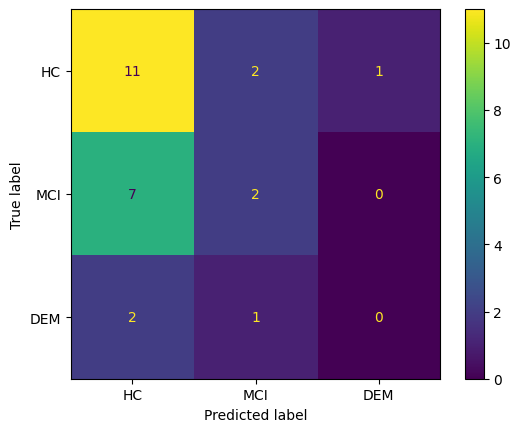

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.386
precision: 0.392
recall: 0.399


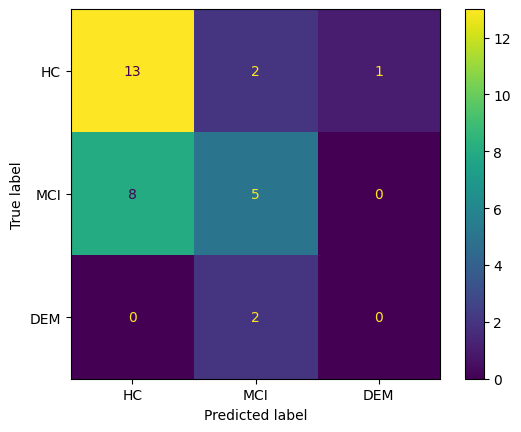

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11406
Epoch 50, Loss: 0.33519
Epoch 100, Loss: 0.00577
Epoch 150, Loss: 0.00185
Epoch 200, Loss: 0.00105
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.581
f1: 0.399
precision: 0.386
recall: 0.413


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


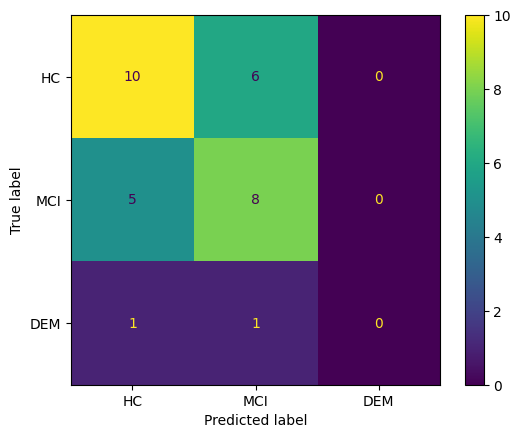

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.09119
Epoch 50, Loss: 0.00283
Epoch 100, Loss: 0.00024
Epoch 150, Loss: 0.00017
Epoch 200, Loss: 0.00012
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.385
f1: 0.261
precision: 0.262
recall: 0.265


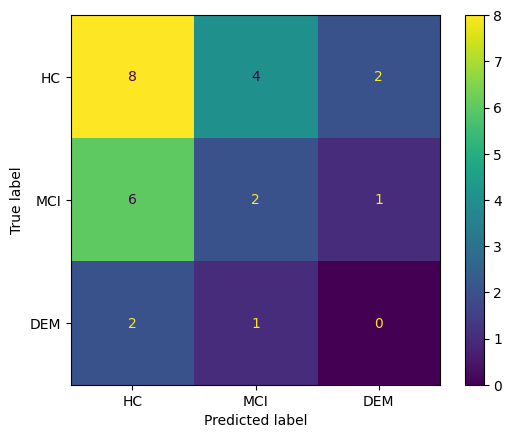

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.548
f1: 0.339
precision: 0.361
recall: 0.369


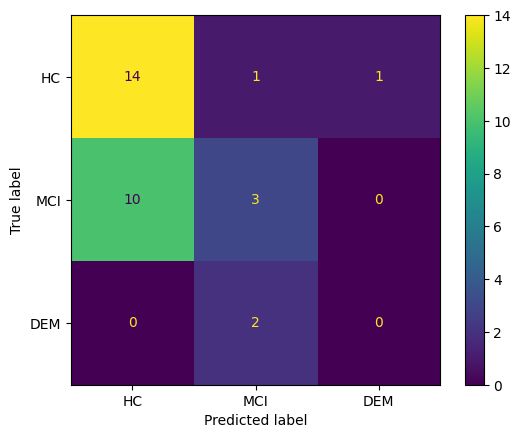

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08675
Epoch 50, Loss: 0.01383
Epoch 100, Loss: 0.00072
Epoch 150, Loss: 0.00041
Epoch 200, Loss: 0.00027
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.337
precision: 0.352
recall: 0.332


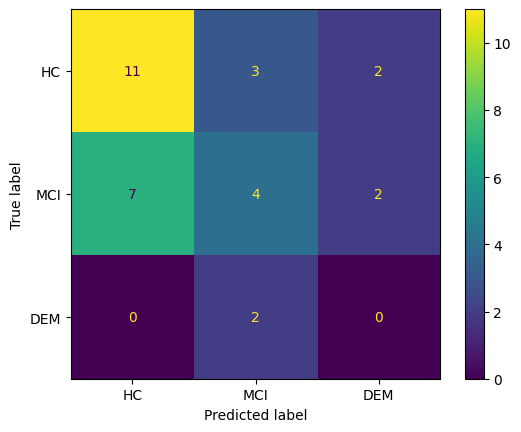

Fold 4:

    train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}),
    train set for meta model: 26 samples; label count: Counter({0: 14, 1: 10, 2: 2}),
    dev set for meta model: 31 samples; label count: Counter({0: 15, 1: 12, 2: 4})
Class weights for base model:  tensor([0.6289, 0.9009, 3.3333])
Class weights for combined model:  tensor([0.6269, 0.8936, 3.5000])
----------- Task: CTD -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.11501
Epoch 50, Loss: 0.49271
Epoch 100, Loss: 0.04340
Epoch 150, Loss: 0.00392
Epoch 200, Loss: 0.00174
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.385
f1: 0.302
precision: 0.333
recall: 0.276


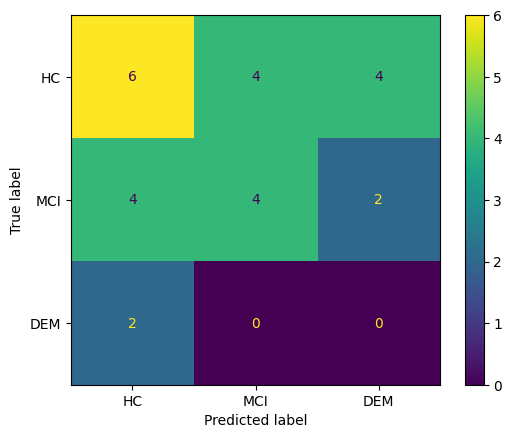

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.276
precision: 0.259
recall: 0.306


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


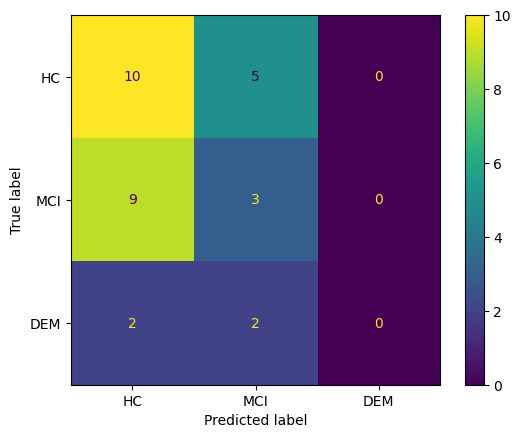

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11510
Epoch 50, Loss: 0.54032
Epoch 100, Loss: 0.08727
Epoch 150, Loss: 0.00825
Epoch 200, Loss: 0.00301
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.452
f1: 0.326
precision: 0.315
recall: 0.339


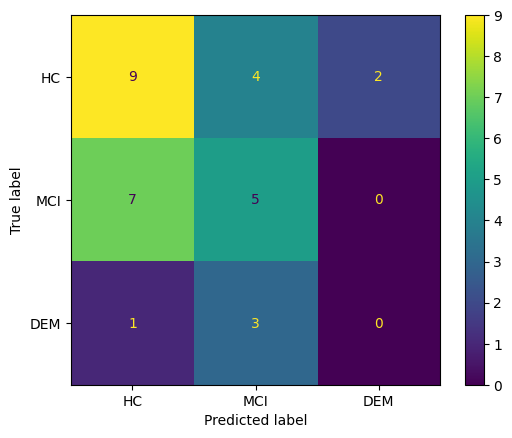

----------- Task: SFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.10895
Epoch 50, Loss: 0.17964
Epoch 100, Loss: 0.00177
Epoch 150, Loss: 0.00077
Epoch 200, Loss: 0.00048
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.462
f1: 0.333
precision: 0.333
recall: 0.333


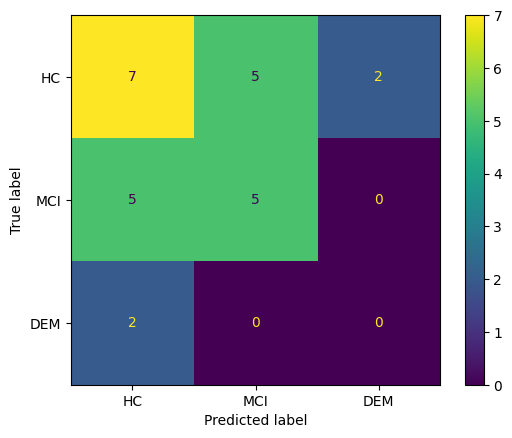

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.419
f1: 0.295
precision: 0.278
recall: 0.317


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


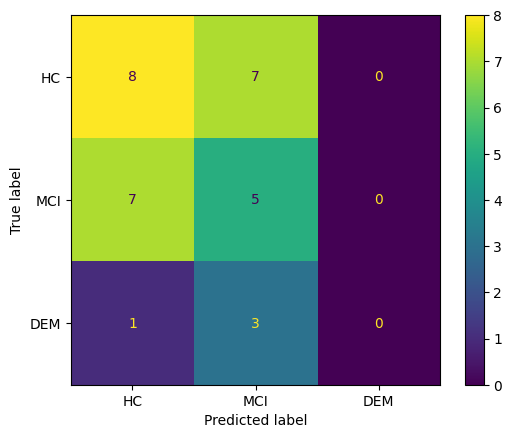

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.11199
Epoch 50, Loss: 0.30834
Epoch 100, Loss: 0.00598
Epoch 150, Loss: 0.00171
Epoch 200, Loss: 0.00094
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.484
f1: 0.335
precision: 0.318
recall: 0.361


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


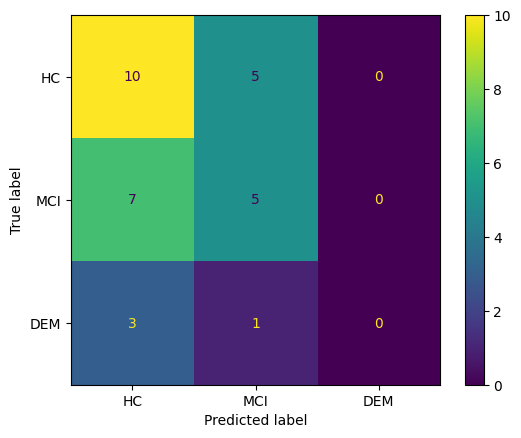

----------- Task: PFT -----------
Training base model...
Setting batch size to  100
Epoch 0, Loss: 1.08392
Epoch 50, Loss: 0.00299
Epoch 100, Loss: 0.00025
Epoch 150, Loss: 0.00016
Epoch 200, Loss: 0.00012
Validating on meta model train set...
Setting batch size to  26
accuracy: 0.346
f1: 0.249
precision: 0.254
recall: 0.252


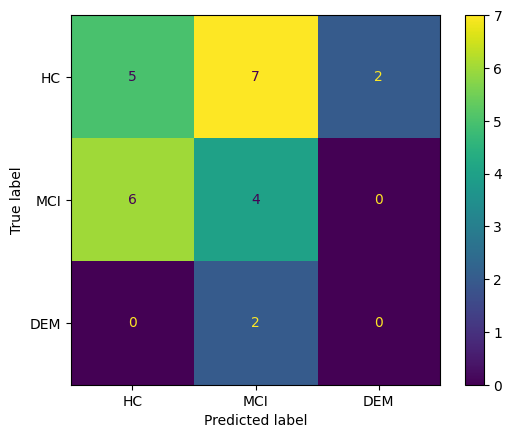

Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.355
f1: 0.329
precision: 0.340
recall: 0.322


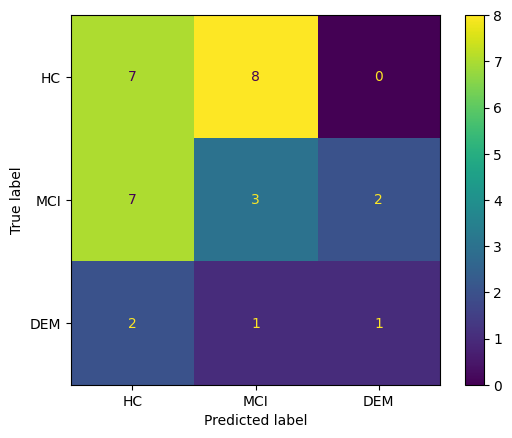

Training on base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 1.08506
Epoch 50, Loss: 0.01188
Epoch 100, Loss: 0.00055
Epoch 150, Loss: 0.00032
Epoch 200, Loss: 0.00022
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.387
f1: 0.340
precision: 0.343
recall: 0.344


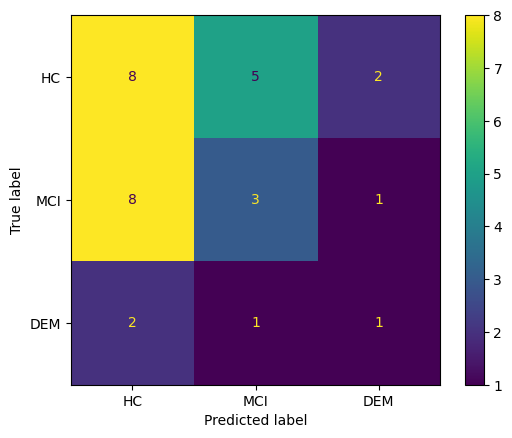

In [31]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TASKS = ['CTD', 'SFT', 'PFT']
LABEL_MAPPING = {'HC': 0,
                 'MCI': 1,
                 'Dementia': 2}

metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
# shuffle df
metadata = metadata.sample(frac=1, random_state=42, ignore_index=False)
metadata['diagnosis_coded'] = metadata['diagnosis'].map(LABEL_MAPPING)

df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf_dict = defaultdict(dict)
for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
    print(f"Fold {fold_index}:")
    base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                    stratify=label_traindev[train_index],
                                                    test_size=0.2)
    print(f'''
    train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
    train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
    dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

    class_weights_base = calculate_class_weights(base_train_label)
    combined_labels = np.concatenate([base_train_label, ensemble_train_label])
    class_weights_combined = calculate_class_weights(combined_labels)
    print('Class weights for base model: ', class_weights_base)
    print('Class weights for combined model: ', class_weights_combined)

    logits_for_ensemble_training = []
    pred_for_ensemble_training = []

    logits_for_ensemble_validation = []
    pred_for_ensemble_validation = []

    for task in TASKS:
        print(f'----------- Task: {task} -----------')
        transcript_folder = f"transcripts_outputFiles/{task}_outputFiles"
        base_train_datalist = get_datalist(base_train_id, base_train_label, transcript_folder)
        ensemble_train_datalist = get_datalist(ensemble_train_id, ensemble_train_label, transcript_folder)
        ensemble_dev_datalist = get_datalist(id_traindev[dev_index], label_traindev[dev_index], transcript_folder)
        # training gnn in order to get the logits
        print('Training base model...')
        trained_gnn = train_gnn(base_train_datalist)
        # get logits and pred for metamodel training
        print('Validating on meta model train set...')
        task_logits_ensemble_training, task_pred_ensemble_training, _, _ = eval_gnn(trained_gnn, ensemble_train_datalist, print_results=False)
        logits_for_ensemble_training.append(task_logits_ensemble_training)
        pred_for_ensemble_training.append(task_pred_ensemble_training)
        # get logits and pred for metamodel validation
        print('Validating on meta model dev set...')
        task_logits_ensemble_validation, task_pred_ensemble_validation, _, _ = eval_gnn(trained_gnn, ensemble_dev_datalist, print_results=False)
        logits_for_ensemble_validation.append(task_logits_ensemble_validation)
        pred_for_ensemble_validation.append(task_pred_ensemble_validation)
        # for comparison: gnn only, no metamodel
        print('Training on base model train set + meta model train set...')
        #trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist, class_weights=class_weights_combined)
        trained_gnn_individual_task = train_gnn(base_train_datalist + ensemble_train_datalist)
        print('Validating on meta model dev set...')
        _, _, kf_dict[fold_index][f'{task}_gnn_results'], kf_dict[fold_index][f'{task}_gnn_cm_disp'] = eval_gnn(trained_gnn_individual_task, ensemble_dev_datalist)
    kf_dict[fold_index]['logits_for_ensemble_training'] = logits_for_ensemble_training
    kf_dict[fold_index]['logits_for_ensemble_validation'] = logits_for_ensemble_validation
    kf_dict[fold_index]['pred_for_ensemble_training'] = pred_for_ensemble_training
    kf_dict[fold_index]['pred_for_ensemble_validation'] = pred_for_ensemble_validation
    kf_dict[fold_index]['ensemble_train_label'] = ensemble_train_label
    kf_dict[fold_index]['ensemble_dev_label'] = label_traindev[dev_index]


Fold 0:
Class weights for fold 0:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...
accuracy: 0.531
f1: 0.386
precision: 0.399
recall: 0.387


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


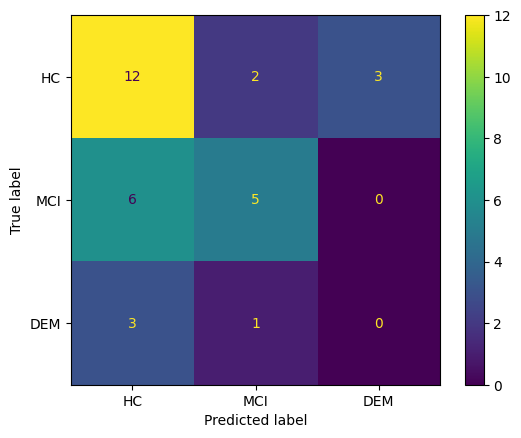

{'accuracy': 0.53125, 'f1': 0.3859649122807018, 'precision': 0.3988095238095238, 'recall': 0.3868092691622103}
Training svm...
accuracy: 0.438
f1: 0.203
precision: 0.161
recall: 0.275


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


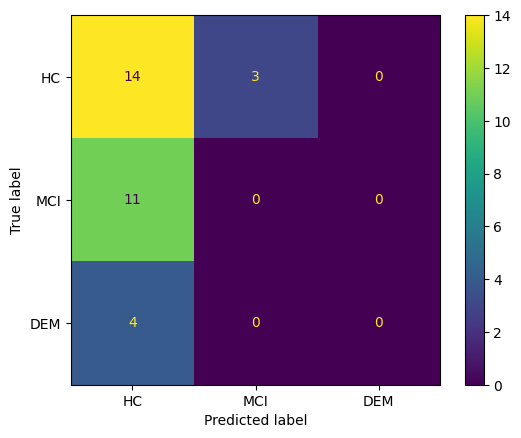

{'accuracy': 0.4375, 'f1': 0.2028985507246377, 'precision': 0.16091954022988506, 'recall': 0.2745098039215686}
Training rf...
accuracy: 0.500
f1: 0.332
precision: 0.315
recall: 0.357


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


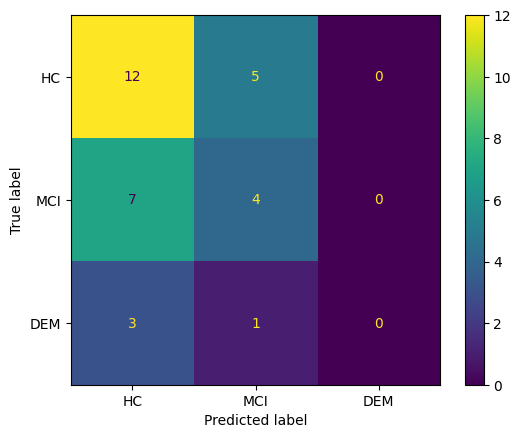

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5, 'f1': 0.3321123321123321, 'precision': 0.3151515151515151, 'recall': 0.35650623885918004}
Training knn...
accuracy: 0.469
f1: 0.213
precision: 0.167
recall: 0.294


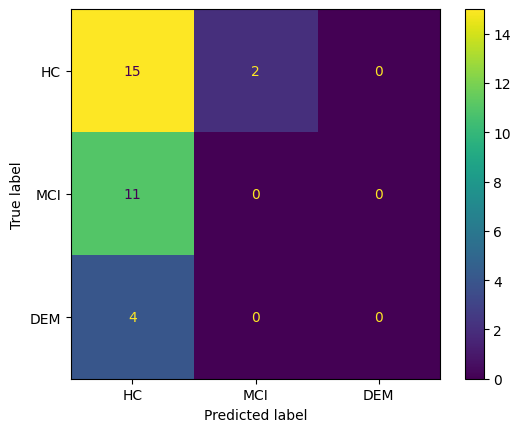

{'accuracy': 0.46875, 'f1': 0.2127659574468085, 'precision': 0.16666666666666666, 'recall': 0.29411764705882354}
Epoch 10, Loss: 0.4891
Epoch 20, Loss: 0.2775
Epoch 30, Loss: 0.1532
Epoch 40, Loss: 0.0862
Epoch 50, Loss: 0.0534
accuracy: 0.500
f1: 0.296
precision: 0.282
recall: 0.335


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


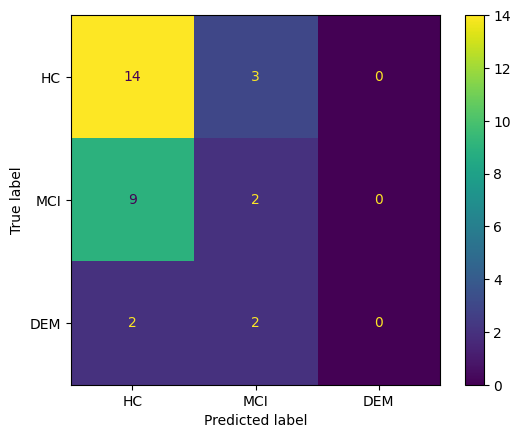

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 1:
Class weights for fold 1:  {0: 0.6410256624221802, 1: 0.8333333134651184, 2: 4.166666507720947}
Training lr...
accuracy: 0.438
f1: 0.348
precision: 0.360
recall: 0.354


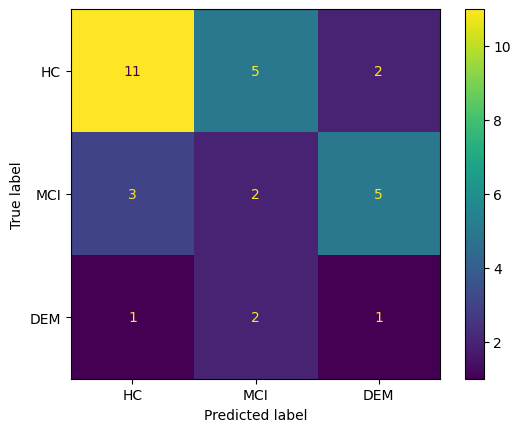

{'accuracy': 0.4375, 'f1': 0.34795321637426896, 'precision': 0.36018518518518516, 'recall': 0.3537037037037037}
Training svm...
accuracy: 0.500
f1: 0.222
precision: 0.178
recall: 0.296


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


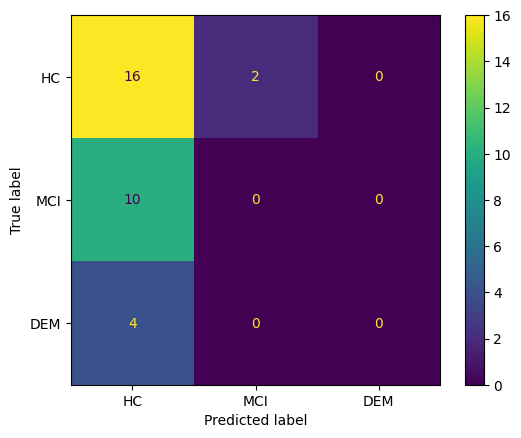

{'accuracy': 0.5, 'f1': 0.2222222222222222, 'precision': 0.17777777777777778, 'recall': 0.2962962962962963}
Training rf...
accuracy: 0.469
f1: 0.315
precision: 0.296
recall: 0.337


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


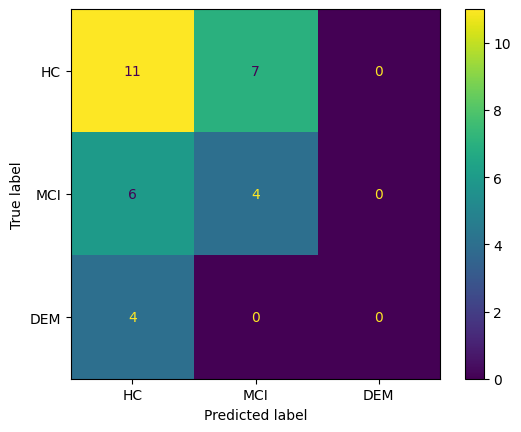

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.46875, 'f1': 0.315018315018315, 'precision': 0.2958152958152958, 'recall': 0.337037037037037}
Training knn...
accuracy: 0.469
f1: 0.325
precision: 0.304
recall: 0.352


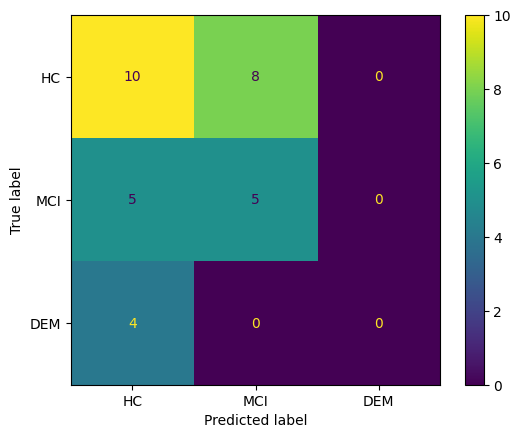

{'accuracy': 0.46875, 'f1': 0.3251077164120642, 'precision': 0.3036437246963563, 'recall': 0.35185185185185186}
Epoch 10, Loss: 0.4138
Epoch 20, Loss: 0.2041
Epoch 30, Loss: 0.1054
Epoch 40, Loss: 0.0505
Epoch 50, Loss: 0.0267
accuracy: 0.375
f1: 0.338
precision: 0.360
recall: 0.361


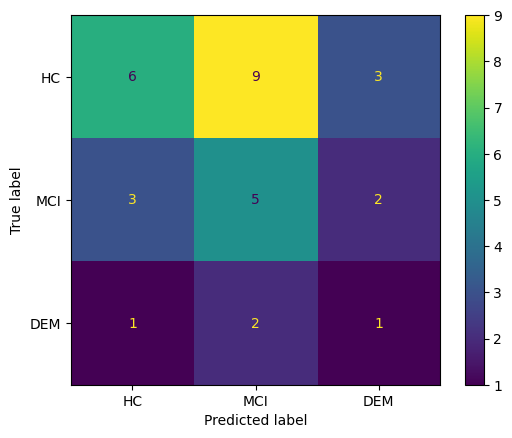

Fold 2:
Class weights for fold 2:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
accuracy: 0.452
f1: 0.312
precision: 0.319
recall: 0.311


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


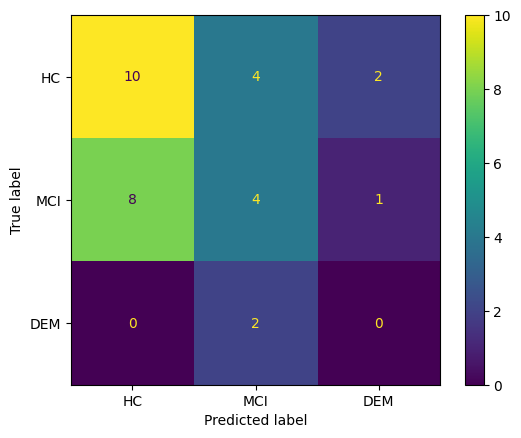

{'accuracy': 0.45161290322580644, 'f1': 0.31202046035805625, 'precision': 0.31851851851851853, 'recall': 0.3108974358974359}
Training svm...
accuracy: 0.516
f1: 0.227
precision: 0.172
recall: 0.333


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


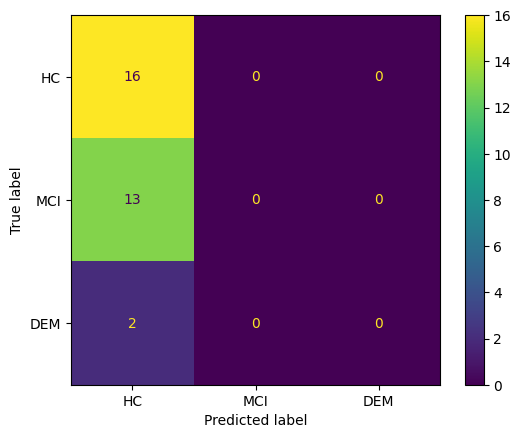

{'accuracy': 0.5161290322580645, 'f1': 0.22695035460992907, 'precision': 0.17204301075268816, 'recall': 0.3333333333333333}
Training rf...
accuracy: 0.484
f1: 0.300
precision: 0.299
recall: 0.327


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


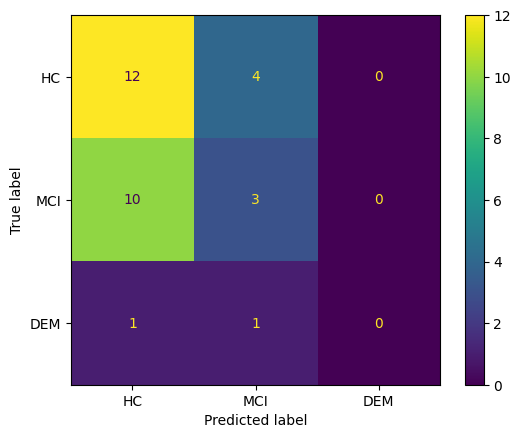

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.4838709677419355, 'f1': 0.30036630036630035, 'precision': 0.29891304347826086, 'recall': 0.3269230769230769}
Training knn...
accuracy: 0.419
f1: 0.233
precision: 0.214
recall: 0.276


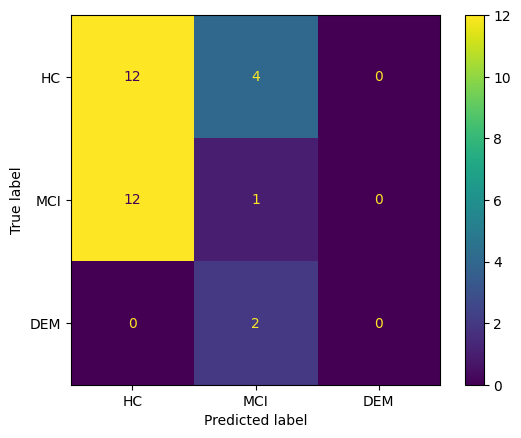

{'accuracy': 0.41935483870967744, 'f1': 0.2333333333333333, 'precision': 0.21428571428571427, 'recall': 0.2756410256410256}
Epoch 10, Loss: 0.6887
Epoch 20, Loss: 0.4382
Epoch 30, Loss: 0.2482
Epoch 40, Loss: 0.1338
Epoch 50, Loss: 0.0664
accuracy: 0.452
f1: 0.310
precision: 0.305
recall: 0.316


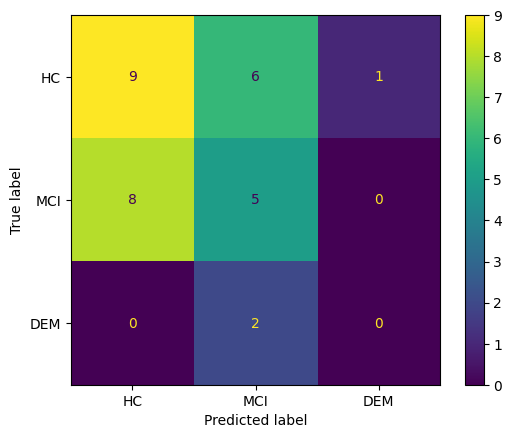

Fold 3:
Class weights for fold 3:  {0: 0.6190476417541504, 1: 0.9629629850387573, 2: 2.8888888359069824}
Training lr...
accuracy: 0.548
f1: 0.368
precision: 0.419
recall: 0.373


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


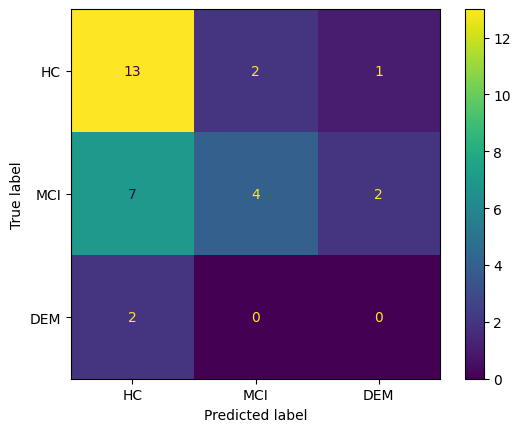

{'accuracy': 0.5483870967741935, 'f1': 0.3684210526315789, 'precision': 0.41919191919191917, 'recall': 0.3733974358974359}
Training svm...
accuracy: 0.452
f1: 0.241
precision: 0.244
recall: 0.296


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


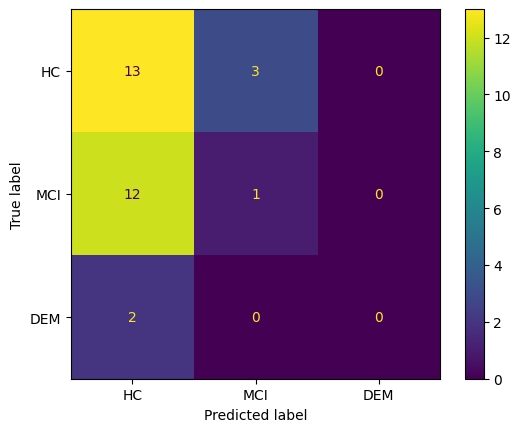

{'accuracy': 0.45161290322580644, 'f1': 0.24076607387140903, 'precision': 0.24382716049382713, 'recall': 0.296474358974359}
Training rf...
accuracy: 0.548
f1: 0.473
precision: 0.520
recall: 0.510


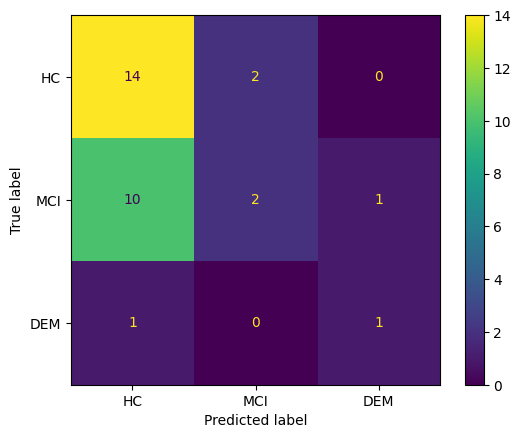

{'accuracy': 0.5483870967741935, 'f1': 0.4727403156384505, 'precision': 0.52, 'recall': 0.5096153846153846}
Training knn...
accuracy: 0.484
f1: 0.254
precision: 0.278
recall: 0.317


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


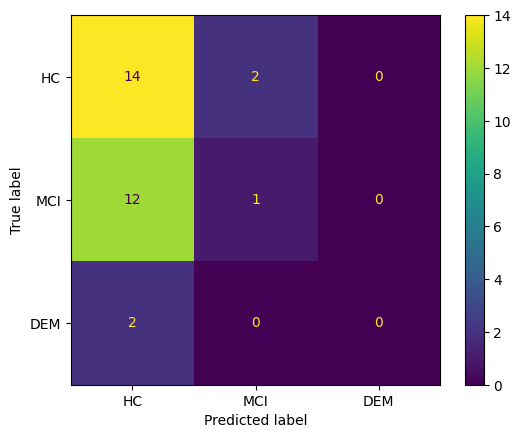

{'accuracy': 0.4838709677419355, 'f1': 0.2537878787878788, 'precision': 0.27777777777777773, 'recall': 0.3173076923076923}
Epoch 10, Loss: 0.5892
Epoch 20, Loss: 0.3282
Epoch 30, Loss: 0.1789
Epoch 40, Loss: 0.1065
Epoch 50, Loss: 0.0634
accuracy: 0.581
f1: 0.519
precision: 0.567
recall: 0.681


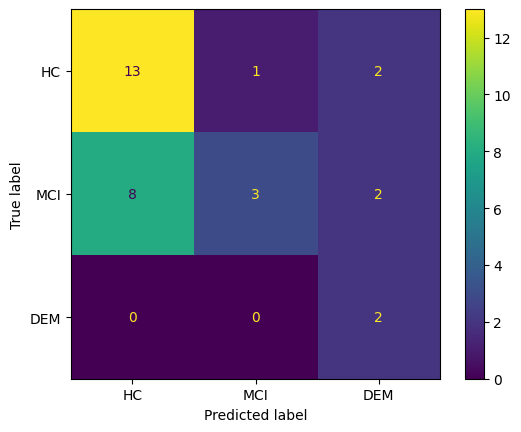

Fold 4:
Class weights for fold 4:  {0: 0.6190476417541504, 1: 0.8666666746139526, 2: 4.333333492279053}
Training lr...
accuracy: 0.355
f1: 0.277
precision: 0.282
recall: 0.272


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


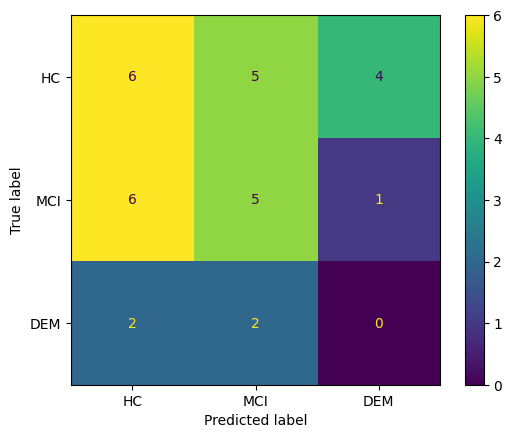

{'accuracy': 0.3548387096774194, 'f1': 0.2768199233716475, 'precision': 0.28174603174603174, 'recall': 0.2722222222222222}
Training svm...
accuracy: 0.484
f1: 0.290
precision: 0.300
recall: 0.344


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


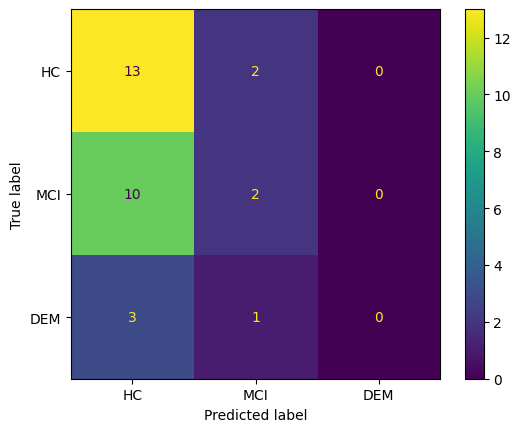

{'accuracy': 0.4838709677419355, 'f1': 0.2898134863701578, 'precision': 0.3, 'recall': 0.3444444444444445}
Training rf...
accuracy: 0.516
f1: 0.327
precision: 0.323
recall: 0.372


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


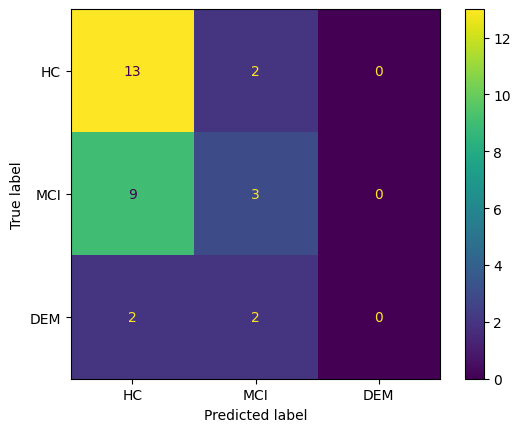

c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5161290322580645, 'f1': 0.32748538011695905, 'precision': 0.3234126984126984, 'recall': 0.37222222222222223}
Training knn...
accuracy: 0.452
f1: 0.274
precision: 0.271
recall: 0.322


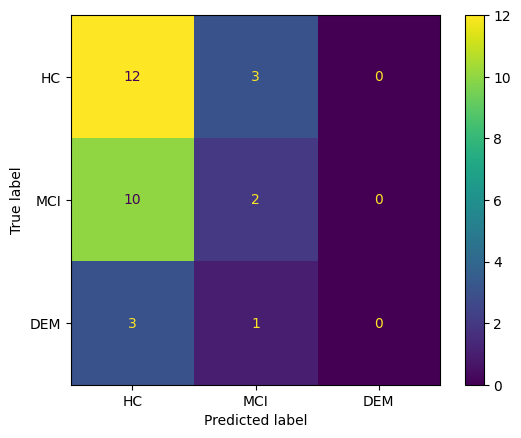

{'accuracy': 0.45161290322580644, 'f1': 0.2740740740740741, 'precision': 0.2711111111111111, 'recall': 0.32222222222222224}
Epoch 10, Loss: 0.5467
Epoch 20, Loss: 0.3285
Epoch 30, Loss: 0.1929
Epoch 40, Loss: 0.1164
Epoch 50, Loss: 0.0747
accuracy: 0.516
f1: 0.448
precision: 0.498
recall: 0.439


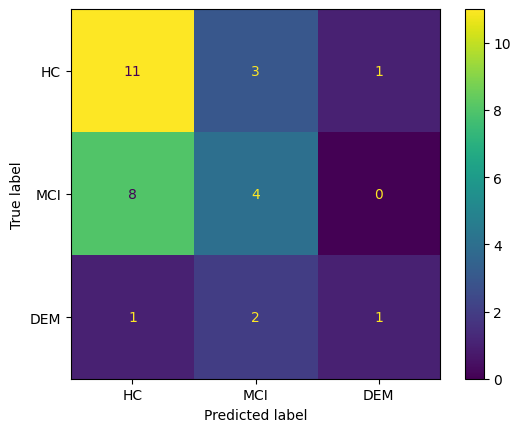

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# train and validate meta models

for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    logits_for_ensemble_training, ensemble_train_label, logits_for_ensemble_validation = fold_dict['logits_for_ensemble_training'], fold_dict['ensemble_train_label'], fold_dict['logits_for_ensemble_validation']
    ensemble_train_features = torch.cat(logits_for_ensemble_training, dim=1).detach()
    ensemble_train_labels = torch.tensor(ensemble_train_label.values, dtype=torch.int64).to(device)
    ensemble_validation_features = torch.cat(logits_for_ensemble_validation, dim=1).detach().to(device)

    class_weights_ensemble = calculate_class_weights(ensemble_train_label)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights_ensemble.tolist())}
    print(f'Class weights for fold {fold}: ', class_weights_dict)

    #lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight=class_weights_dict)
    #svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=class_weights_dict)
    #rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight=class_weights_dict)
    knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
    lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # apply machine learning models as metamodel:
    for model_name, ensemble_model in {'lr': lr_model, 'svm': svm_model, 'rf': rf_model, 'knn': knn_model}.items():
        print(f'Training {model_name}...')
        ensemble_model.fit(ensemble_train_features, ensemble_train_labels)
        y_pred = ensemble_model.predict(ensemble_validation_features)
        ensemble_validation_labels = fold_dict['ensemble_dev_label'].to_numpy()
        kf_dict[fold][f'metamodel_{model_name}_results'], kf_dict[fold][f'metamodel_{model_name}_cm_disp'] = calc_metrics(ensemble_validation_labels, y_pred)
        print(kf_dict[fold][f'metamodel_{model_name}_results'])
    # apply nn model as metamodel:
    #nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels, class_weights=class_weights_ensemble)
    nn_meta_model = train_nn_metamodel(features=ensemble_train_features, labels=ensemble_train_labels)
    nn_meta_model.eval()
    with torch.no_grad():
        ensemble_validation_labels = torch.tensor(fold_dict['ensemble_dev_label'].values, dtype=torch.int64).to(device)
        validation_pred = nn_meta_model(ensemble_validation_features).argmax(dim=1)
        kf_dict[fold][f'metamodel_nn_results'], kf_dict[fold][f'metamodel_nn_cm_disp'] = calc_metrics(ensemble_validation_labels, validation_pred)


In [33]:
# view results
TASKS = ['CTD', 'SFT', 'PFT']
f1_scores = defaultdict(list)
for fold in kf_dict.keys():
    print(f"Fold {fold}:")
    fold_dict = kf_dict[fold]
    print('F1 scores')
    for metmodel_name in ['lr', 'svm', 'rf', 'knn', 'nn']:
        f1 = fold_dict[f'metamodel_{metmodel_name}_results']['f1']
        print(f'metamodel_{metmodel_name} {f1:.2f}')
        f1_scores[metmodel_name].append(f1)
    for task in TASKS:
        f1 = fold_dict[f'{task}_gnn_results']['f1']
        print(f'{task}_gnn {f1:.2f}')
        f1_scores[f'{task}_gnn'].append(f1)

for key in f1_scores.keys():
    print(f'{key} mean f1: {np.mean(f1_scores[key]):.4f}')
    print(f'{key} std f1: {np.std(f1_scores[key]):.4f}')


Fold 0:
F1 scores
metamodel_lr 0.39
metamodel_svm 0.20
metamodel_rf 0.33
metamodel_knn 0.21
metamodel_nn 0.30
CTD_gnn 0.29
SFT_gnn 0.34
PFT_gnn 0.46
Fold 1:
F1 scores
metamodel_lr 0.35
metamodel_svm 0.22
metamodel_rf 0.32
metamodel_knn 0.33
metamodel_nn 0.34
CTD_gnn 0.42
SFT_gnn 0.38
PFT_gnn 0.37
Fold 2:
F1 scores
metamodel_lr 0.31
metamodel_svm 0.23
metamodel_rf 0.30
metamodel_knn 0.23
metamodel_nn 0.31
CTD_gnn 0.36
SFT_gnn 0.42
PFT_gnn 0.29
Fold 3:
F1 scores
metamodel_lr 0.37
metamodel_svm 0.24
metamodel_rf 0.47
metamodel_knn 0.25
metamodel_nn 0.52
CTD_gnn 0.36
SFT_gnn 0.40
PFT_gnn 0.34
Fold 4:
F1 scores
metamodel_lr 0.28
metamodel_svm 0.29
metamodel_rf 0.33
metamodel_knn 0.27
metamodel_nn 0.45
CTD_gnn 0.33
SFT_gnn 0.34
PFT_gnn 0.34
lr mean f1: 0.3382
lr std f1: 0.0394
svm mean f1: 0.2365
svm std f1: 0.0293
rf mean f1: 0.3495
rf std f1: 0.0626
knn mean f1: 0.2598
knn std f1: 0.0385
nn mean f1: 0.3820
nn std f1: 0.0865
CTD_gnn mean f1: 0.3527
CTD_gnn std f1: 0.0423
SFT_gnn mean f1: 0.